# Exercises

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import pearsonr

In [67]:
# Determine the time step, standard deviation and size of visual field
dt = .1
std_dev = 1
vf_size = (15,15)

# Create the Gabor filter
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

In [68]:
# Function to generate the neural responses
def neural_response(K, S, noise_variance=1, offset=2.):
    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    rate = ks

    # add Gaussian noise centered around the "true" rate for each bin
    rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)
    
    return S_flat, rate

In [69]:
# Function for least squares procedure
def apply_lsq(S_flat, rate, vf_size):
    #S_flat = S_flat.T
    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
    K_hat = K_hat[:-1].reshape(vf_size)
    
    return K_hat

In [70]:
# Determine the different durations
durations = [5., 10., 20., 40., 80., 160., 320., 640.]

# Store the average correlations across 10 realizations in a list
avg_correlation = []

for duration in durations:
    # Store each correlation value from the 10 iterations 
    correlations = []
    # For each duration compute 10 realizations
    for _ in range(10):
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        S_flat, rate = neural_response(K, S)
        K_hat = apply_lsq(S_flat, rate, vf_size)
        cc = pearsonr(K.flatten(), K_hat.flatten())[0]
        correlations.append(cc)
    avg_correlation.append(np.mean(correlations))

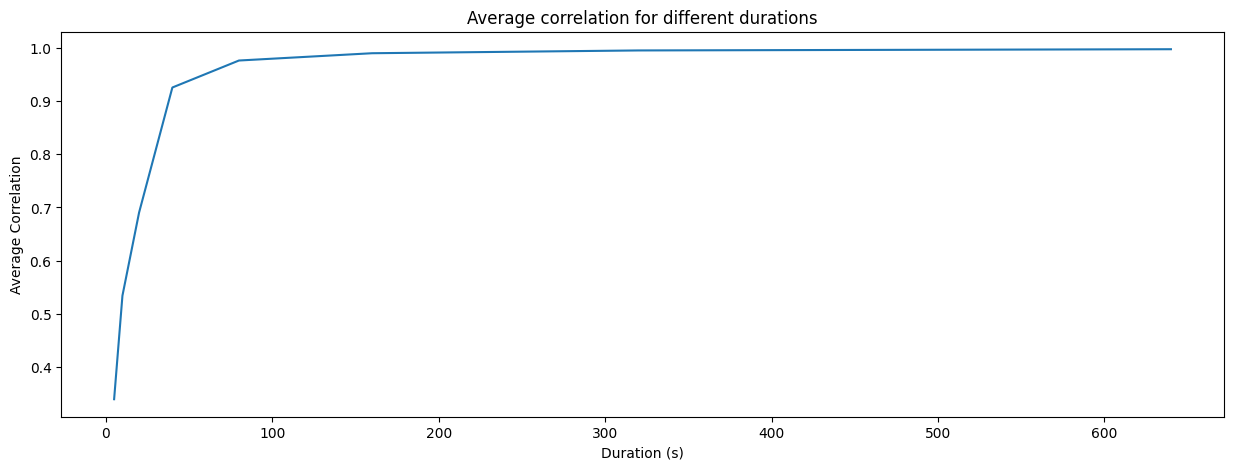

In [72]:
plt.figure(figsize=(15,5))
plt.title('Average correlation for different durations')
plt.plot(durations, avg_correlation)
plt.xlabel('Duration (s)')
plt.ylabel('Average Correlation')
plt.show()

### Comments Exercise 1:
As can be seen in the plot above, the average Pearson correlation becomes higher for longer durations. This means that if the duration is longer, the accuracy to recover the true RF becomes higher. Till around 40s, a steep increase in the average correlation can be seen and the average correlation will afterwards flatten to a correlation value of above 0.90.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

In [93]:
# Determine the duration
duration = 100.

# Determine the different noise variances
noise_variances = [0, 2, 4, 6, 8, 10]

# Store the average correlations across 10 realizations in a list
avg_correlation = []
# Store the standard deviations for different noise variance values in a list
std_correlation = []

 

for noise in noise_variances:
    # Store each correlation value from the 10 iterations 
    correlations = []
    # For each duration compute 10 realizations
    for _ in range(10):
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
        S_flat, rate = neural_response(K, S, noise_variance=noise)
        K_hat = apply_lsq(S_flat, rate, vf_size)
        cc = pearsonr(K.flatten(), K_hat.flatten())[0]
        correlations.append(cc)
    avg_correlation.append(np.mean(correlations))
    std_correlation.append(np.std(correlations))

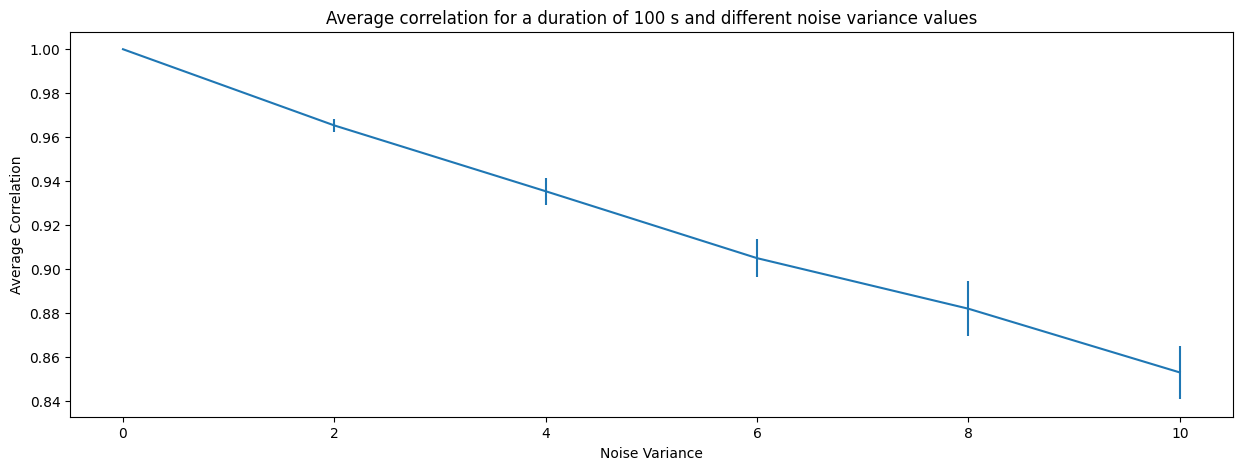

In [95]:
plt.figure(figsize=(15,5))
plt.title('Average correlation for a duration of 100 s and different noise variance values')
plt.errorbar(noise_variances, avg_correlation, yerr=std_correlation)
plt.xlabel('Noise Variance')
plt.ylabel('Average Correlation')
plt.show()

### Comments Exercise 2:
As can be seen in the plot above, the average correlation decreases between the true and estimated RF when the noise variance value increases. A higher noise variance means that the neural respons will have more noise, and thus more random values that differ from the true RF. As the noise variance value increases, the standard deviation will also have an increasing trend. 

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 


### Comments Exercise 3:
The function is defined as:
$$
    \lambda_t = f(\mathbf{k}^T \mathbf{s}_t)
$$ 

Log-likelihood for a single observation (at time $t$):

\begin{equation}
    \log P(r_t | \lambda_t) = r_t\log \lambda_t + r_t\log \Delta - \log r_t! - \lambda_t \Delta.
\end{equation}

Thus the log-likelihood for the whole spike sequence is given by

\begin{equation}
    \log P(R | \lambda) = \sum_t r_t\log \lambda_t + \sum_t r_t\log \Delta - \sum_t \log r_t! - \sum_t \lambda_t \Delta.
\end{equation}

Because $ \lambda_t = f(\mathbf{k}^T \mathbf{s}_t)$, every term that is not multiplied with $\lambda_t $ is not required for maximizing the likelihood with respect to $\mathbf{k}$. 

So terms that are required: \
$\sum_t r_t\log \lambda_t$ and $\sum_t \lambda_t \Delta$  

Terms that can be ignored: \
$\sum_t r_t\log \Delta$ and $\sum_t \log r_t!$

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

### Exercise 4A

In [110]:
# Determine the time step, standard deviation and size of visual field
dt = .1
std_dev = 1
vf_size = (15,15)
offset = 2.

# Determine average firing rate
spike_rate = 5

In [111]:
def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

In [112]:
# Function to generate the neural responses
def neural_response(K, S, spike_rate, duration):
    # flatten the matrices in to 1d array for convenience
    K_flat = K.ravel()
    K_flat = np.hstack((K.flat, offset))

    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    # 1. linear stage
    ks = np.dot(K_flat, S_flat.T)

    # 2. nonlinear stage (for a linear model: f -> identity function)
    lamda = np.exp(ks)

    # lamda * dt is the number of spikes in the different bins (but keep in mind that the Poisson process
    # is a stochastic process so the actual number will differ for every draw). Thus, the sum of the product 
    # across all bins gives the expected number of spikes for the whole draw.
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    
    # generate spike times using an inhomogeneous Poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)

    # compute spike counts in the different time bins
    spike_counts = np.histogram(spike_times, bins=np.arange(n_bins+1)*dt)[0]
    
    return spike_counts, S_flat, K_flat

In [113]:
from scipy.optimize import minimize

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

In [116]:
# Determine the different durations
durations = [10., 20., 50., 100., 200.]

# List to store the correlations for different durations of data
corr_poisson4a = []

for duration in durations:
    n_bins = round(duration / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    spike_counts, S_flat, K_flat = neural_response(K, S, spike_rate, duration)
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    # Why divided by 10? 
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    cc = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    corr_poisson4a.append(cc)
    

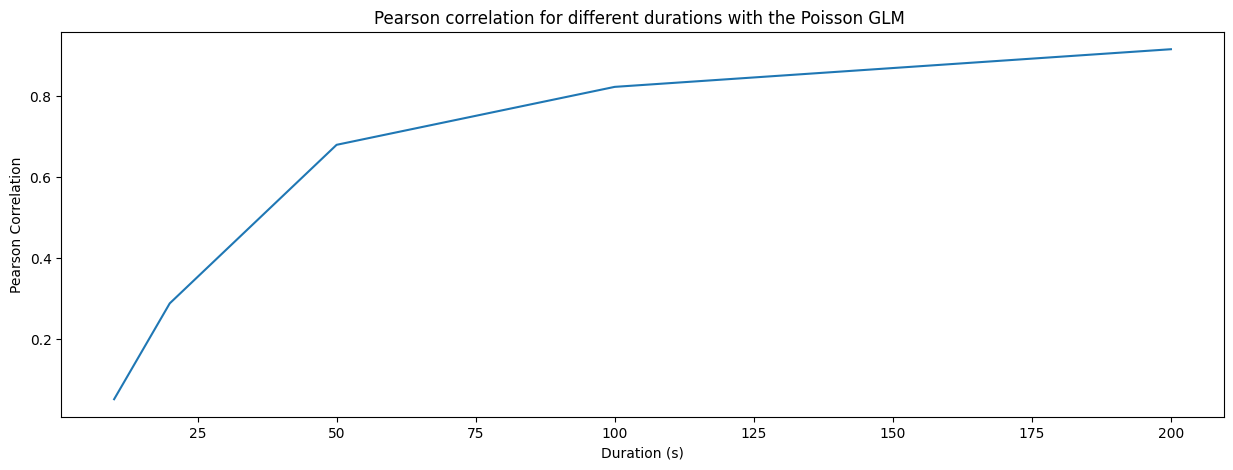

In [117]:
plt.figure(figsize=(15,5))
plt.title('Pearson correlation for different durations with the Poisson GLM ')
plt.plot(durations, corr_poisson4a)
plt.xlabel('Duration (s)')
plt.ylabel('Pearson Correlation')
plt.show()

### Comments Exercise 4A:
Both the GLM plot from exercise 1 and the Poisson GLM plot show an increase of the Pearson correlation for longer data durations.  

### Exercise 4B

In [148]:
# Determine the different durations
duration = 100

# List with different firing rates
firing_rates = [1, 3, 5, 10, 30, 40, 50, 60]

# List to store the correlations for different durations of data
corr_poisson4b = []

for spike_rate in firing_rates:
    n_bins = round(duration / float(dt))
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    spike_counts, S_flat, K_flat = neural_response(K, S, spike_rate, duration)
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts) 
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    cc = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    corr_poisson4b.append(cc)
    

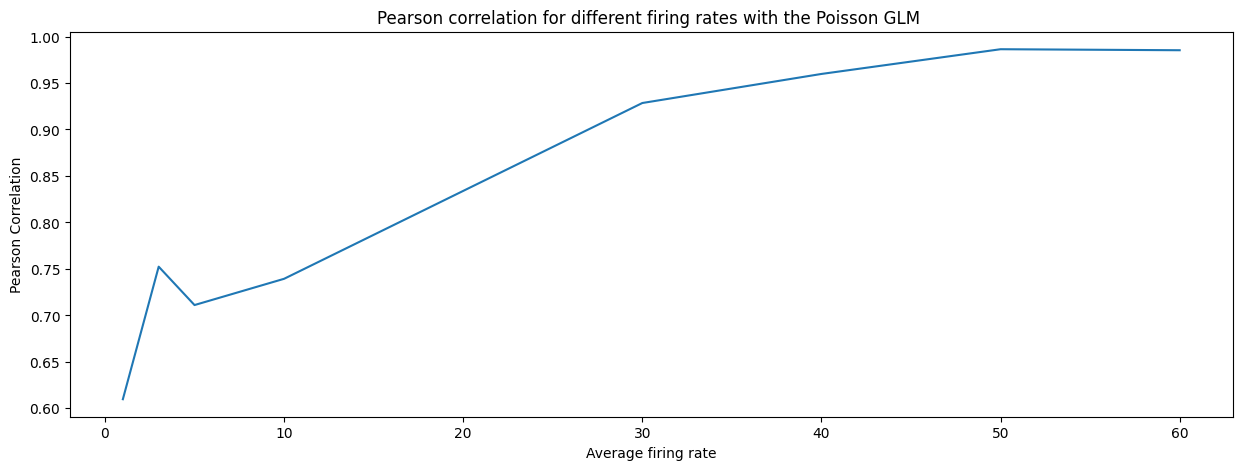

In [149]:
plt.figure(figsize=(15,5))
plt.title('Pearson correlation for different firing rates with the Poisson GLM ')
plt.plot(firing_rates, corr_poisson4b)
plt.xlabel('Average firing rate')
plt.ylabel('Pearson Correlation')
plt.show()

### Comments Exercise 4B:
As can be seen in the plot above, a higher firing rate value means that the Pearson correlation increases. The firing rate has a stable correlation from a firing rate of approximately 40. 
\
A firing rate that is set too high (for example above 200) will result in a RuntimeWarning.